# Homework 2 - IS-Academia

In [1]:
import requests as rq
from bs4 import BeautifulSoup as bfs
import numpy as np
import pandas as pd
import collections
import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from dateutil import relativedelta
import scipy.stats as stats
import math

# Question 1 - Bachelor

Obtain all the data for the Bachelor students, starting from 2007. Keep only the students for which you have an entry for both Bachelor semestre 1 and Bachelor semestre 6. Compute how many months it took each student to go from the first to the sixth semester. Partition the data between male and female students, and compute the average -- is the difference in average statistically significant?</b>

Firstly, we define some constants that will be usefull for all questions. The two URL have been found with Postman.

In [2]:
DATA_FOLDER = 'Data/'
DATA_URL = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html'
FILTER_URL = 'http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.filter?ww_i_reportModel=133685247'

## Get params

In order to get all students data, we need to get all parameters available to fetch the database by the REST API. To do so, we begin by request the section that display all `select` lists in the web page. Then, we extract for each options the humain readable name with his corresponding value.

In [3]:
filters_page = rq.get(FILTER_URL)
filters = bfs(filters_page.text, 'html.parser')
selects = filters.findAll('select')

available_params = collections.defaultdict(dict)

for select in selects:    
    options = collections.defaultdict(list)
    
    for option in select.findAll('option'):
        if option.attrs['value'] != 'null':
            options[option.text] = option.attrs['value']
        
    available_params[select.attrs['name']] = options
  
available_params

defaultdict(dict,
            {'ww_x_HIVERETE': defaultdict(list,
                         {"Semestre d'automne": '2936286',
                          'Semestre de printemps': '2936295'}),
             'ww_x_PERIODE_ACAD': defaultdict(list,
                         {'2007-2008': '978181',
                          '2008-2009': '978187',
                          '2009-2010': '978195',
                          '2010-2011': '39486325',
                          '2011-2012': '123455150',
                          '2012-2013': '123456101',
                          '2013-2014': '213637754',
                          '2014-2015': '213637922',
                          '2015-2016': '213638028',
                          '2016-2017': '355925344'}),
             'ww_x_PERIODE_PEDAGO': defaultdict(list,
                         {'Bachelor semestre 1': '249108',
                          'Bachelor semestre 2': '249114',
                          'Bachelor semestre 3': '942155',
                

### Making params names readable

Now, we have all available parameters, but there are not easy to read. To improve this, we have made the choice to directly see the source code in the HTML page and make the correspondance because there are very few `select` box (so it's faster than extract this information directly in python).

Every constants represent a parameter name. We define in addition a dictionary of default params needed in all requests we will make.

In [4]:
SECTION_PARAM = 'ww_x_UNITE_ACAD' # like 'Informatique' => Computer Sciences
YEAR_PARAM = 'ww_x_PERIODE_ACAD' # like '2016-2017'
SEMESTER_PARAM = 'ww_x_PERIODE_PEDAGO' # like 'Bachelor semestre 1' => Bachelor semester 1
TYPE_PARAM = 'ww_x_HIVERETE' # like 'Semestre d'automne' => Fall semester

DEFAULT_PARAMS = {
    'ww_x_GPS' : '-1',
    'ww_i_reportModel' : '133685247',
    'ww_i_reportModelXsl' : '133685270',
}

section_codes = available_params[SECTION_PARAM]
year_codes = available_params[YEAR_PARAM]
semester_codes = available_params[SEMESTER_PARAM]
type_codes = available_params[TYPE_PARAM]

## Get data

Firstly, we make a function that return a single dataframe from the html table extracted from a requested page.

We try to get columns from table header. But in our case, all tables have two header rows, the first one is the title of the table and the second one is the colum names.

Then, we fetch all rows to convert them to a single serie (list of column values in this row).
Finally, we combine columns names and series in a new pandas DataFrame.

In [5]:
def html_page_to_dataframe(page):
    soup = bfs(page.text, 'html.parser')
    table = soup.find('table')
    
    # Get columns names, skip the first column that show the section and year
    columns = [column.text for column in table.find_all('th')[1:]]
    
    series = []
    # Fetch all rows to a serie, skip the two first rows that represent header
    for row in table.find_all('tr')[2:]:
        serie = []
        
        # Fetch all columns, but skip the last one that is not in the header (badly structered html table)
        for col in row.find_all('td')[:-1]:
            serie.append(col.text)
        series.append(serie)

    # Create a dataframe from the columns and series variable
    df = pd.DataFrame(series)
    df.columns = columns
    
    return df

Now, we are able to request a IS-Academia page containing the data table of students in a specific section, year and semester.
We will store all data, to avoid multiple requests and DDOS the IS-Academia access. To do so, we will use pickle to serialize all data :

In [6]:
# Create the directory Data if not exist
if not os.path.exists('Data'):
    os.makedirs(DATA_FOLDER)

# We focus only one data of students in bachelor and master
bachelor_master_semester_codes = {}
for section_name in semester_codes:
    if section_name.startswith('Bachelor semestre') or section_name.startswith('Master semestre') or section_name.startswith('Projet Master'):
            bachelor_master_semester_codes[section_name] = semester_codes[section_name]

print('Start fetching data from ' + DATA_URL)

# For each codes available in the year select box
for year_name, year_code in year_codes.items():

    # For each codes about master and bachelor sections
    for semester_name, semester_code in bachelor_master_semester_codes.items():
        
        print('\tFetch data for ' + year_name + ' ' + semester_name + '\t: ', end="", flush=True)

        file_path = DATA_FOLDER + year_name + ' ' + semester_name
        
        # If the file already exist do nothing more
        if not os.path.exists(file_path):
       
            params = {
                SECTION_PARAM : section_codes['Informatique'],
                YEAR_PARAM : year_code,
                SEMESTER_PARAM : semester_code,
                TYPE_PARAM : 'null',
                **DEFAULT_PARAMS
            }

            try:
                # We get a dataframe from a table in the html
                data = html_page_to_dataframe(rq.get(DATA_URL, params))

                if data.empty:
                    print('No data')
                    
                else:
                    # We store data in binary file with pickle in the Data folder
                    data.to_pickle(file_path)

                    print('Stored in ' + file_path)

            except ValueError:
                print('Unable to get data from ' + DATA_URL + ' with following params :')
                for key, value in params.items():
                    print('\t\t' + key + ' : ' + value)
                break

        else:
            print('Already stored in ' + file_path)

print('Fetching data done, see ' + DATA_FOLDER + ' folder')

Start fetching data from http://isa.epfl.ch/imoniteur_ISAP/!GEDPUBLICREPORTS.html
	Fetch data for 2015-2016 Bachelor semestre 6b	: No data
	Fetch data for 2015-2016 Bachelor semestre 3	: Stored in Data/2015-2016 Bachelor semestre 3
	Fetch data for 2015-2016 Bachelor semestre 5	: Stored in Data/2015-2016 Bachelor semestre 5
	Fetch data for 2015-2016 Projet Master automne	: Stored in Data/2015-2016 Projet Master automne
	Fetch data for 2015-2016 Bachelor semestre 1	: Stored in Data/2015-2016 Bachelor semestre 1
	Fetch data for 2015-2016 Master semestre 1	: Stored in Data/2015-2016 Master semestre 1
	Fetch data for 2015-2016 Master semestre 4	: No data
	Fetch data for 2015-2016 Bachelor semestre 2	: Stored in Data/2015-2016 Bachelor semestre 2
	Fetch data for 2015-2016 Bachelor semestre 6	: Stored in Data/2015-2016 Bachelor semestre 6
	Fetch data for 2015-2016 Projet Master printemps	: No data
	Fetch data for 2015-2016 Bachelor semestre 4	: Stored in Data/2015-2016 Bachelor semestre 4
	Fe

> Problem detected with "2008-2009 Bachelor semestre 3" and "2007-2008 Bachelor semestre 3", multiple table find (two entry instead of one). We have only two errors so if we need this data we will make the request manually.

### Analyse bachelor data

We can notice that the data related to students in bachelor 5b and 6b are empty in computer science section.

Assumptions:
 - 1) A bachelor student starts at the semester 1 and finishes at the semester 6 or 5 (if the student failed his semester 5 but not the 6)
 - 2) A semester lasts 6 months
 - 3) Odd semesters are in the fall period and even semesters are in the spring semesters
 
Now, we need to get interested data from files and concat all together in a single dataframe. We firstly concat every data of one section in one dataframe like this:

In [7]:
## Get data from files and return a table of dataframes for every sections given
# semester_codes: dict (section name : section code) that the function will retrieve
# extra_compute: extra function executed in every year for a specific section (params: data for this year, semester name and year name)
# data_folder: the data folder where data is stored (by default DATA_FOLDER constant)
def retrieve_dataframes(semester_codes, extra_compute, data_folder=DATA_FOLDER):

    # The variable contains a list of dataframe associated to a semester_name
    dataframes = collections.defaultdict(pd.DataFrame)

    for semester_name, semester_code in semester_codes.items():

        print('Compute for ' + semester_name)

        # The variable contains a list of dataframe related to a specific semester.
        for year_name, year_code in year_codes.items():

            file_path = data_folder + year_name + ' ' + semester_name

            if os.path.exists(file_path):

                # We get a dataframe from a table in the html
                data_per_year = pd.read_pickle(file_path)

                extra_compute(data_per_year, semester_name, year_name)

                # We add the result to the initial dataframe
                dataframes[semester_name] =  pd.concat([dataframes[semester_name], data_per_year])
                
    return dataframes

In [8]:
# We select only semester 1, 5, 6 in the bachelor section
bachelor_semester_codes = {}
for section_name in semester_codes:
    if section_name.startswith('Bachelor semestre') and section_name.endswith(tuple(['1', '5', '6'])):
        bachelor_semester_codes[section_name] = semester_codes[section_name]

# This is the extra function given to the previous function that will add a column with the beginning date of the semester
# 1 August for odd semesters and 1 February for even semesters
def bachelor_append_year(data_per_year, semester_name, year_name):
    if semester_name.endswith('1') or semester_name.endswith('5'):
        begin_date = year_name.split('-')[0] + '-08-01'
    else:
        begin_date = year_name.split('-')[1] + '-02-01'
    data_per_year[semester_name] = pd.to_datetime(begin_date) 

bachelor_dataframes = retrieve_dataframes(bachelor_semester_codes, bachelor_append_year)

Compute for Bachelor semestre 6
Compute for Bachelor semestre 1
Compute for Bachelor semestre 5


## Visualizing and cleaning data

In [9]:
bachelor_data_semester1 = bachelor_dataframes['Bachelor semestre 1'].copy()
bachelor_data_semester1.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Bachelor semestre 1
0,Monsieur,Abbey Alexandre,,,,,,Présent,,,235688,2015-08-01
1,Madame,Abboud Magaly,,,,,,Présent,,,249344,2015-08-01
2,Monsieur,Ahmed Fares,,,,,,Présent,,,246443,2015-08-01
3,Monsieur,Alder Jean-Marie René,,,,,,Présent,,,259105,2015-08-01
4,Madame,Amirthalingam Ajantha,,,,,,Présent,,,262227,2015-08-01


In [10]:
bachelor_data_semester5 = bachelor_dataframes['Bachelor semestre 5'].copy()
bachelor_data_semester5.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Bachelor semestre 5
0,Monsieur,Aiulfi Loris Sandro,,,,,,Congé,,,202293,2015-08-01
1,Monsieur,Alfonso Peterssen Alfonso,,,,6 - Visual computing,,Présent,,,228219,2015-08-01
2,Monsieur,Alonso Seisdedos Florian,,,,,,Présent,,,215576,2015-08-01
3,Monsieur,Angerand Grégoire Georges Jacques,,,,,,Présent,,,212464,2015-08-01
4,Monsieur,Anongba Varela Dario Abougnan,,,,7 - Biocomputing,,Présent,,,226371,2015-08-01


In [11]:
bachelor_data_semester6 = bachelor_dataframes['Bachelor semestre 6'].copy()
bachelor_data_semester6.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,No Sciper,Bachelor semestre 6
0,Monsieur,Aiulfi Loris Sandro,,,,,,Congé,,,202293,2016-02-01
1,Monsieur,Alfonso Peterssen Alfonso,,,,6 - Visual computing,,Présent,,,228219,2016-02-01
2,Monsieur,Alonso Seisdedos Florian,,,,,,Présent,,,215576,2016-02-01
3,Monsieur,Angerand Grégoire Georges Jacques,,,,,,Présent,,,212464,2016-02-01
4,Monsieur,Anongba Varela Dario Abougnan,,,,6 - Visual computing,,Présent,,,226371,2016-02-01


### About the student status

We see a status column that shows if the student is present or not in the semester. This parameter can have an impact on the result we want to compute:

In [12]:
bachelor_data_semester1['Statut'].value_counts()

Présent    1529
Congé         3
Attente       1
Name: Statut, dtype: int64

In [13]:
bachelor_data_semester5['Statut'].value_counts()

Présent    648
Congé      137
Name: Statut, dtype: int64

In [14]:
bachelor_data_semester6['Statut'].value_counts()

Présent    447
Congé      127
Attente      1
Name: Statut, dtype: int64

We have some students who didn't attend the first or last semester and only one (in semester 1 and 6) in a waiting state.
We can't know with this data if a student registered in bachelor semester 6 has successfully achieved his bachelor degree or not (i.e. a student can be marked as "présent" or "congé" and in the same time can fail or success). For this reasons we have to make new assumptions :
 - 4) The earliest year of bachelor semester 1 stored in database correspond to the begining of his bachelor plan, regardless the status of students ('Présent', 'Congé' or 'Attente')
 - 5) We consider that all students obtain their bachelor regardless their status for the bachelor semester 1 and bachelor semester 6 (obviously, they have to be still present at bachelor semester 6).
 
 > Note: The fifth assumption is not mandatory here as we just want to know the average duration of a bachelor study plan.

### Handle duplicate entries and making index

We want a unique index, in our case this will be the Sciper number :

In [15]:
bachelor_data_semester1['No Sciper'].is_unique

False

In [16]:
bachelor_data_semester5['No Sciper'].is_unique

False

In [17]:
bachelor_data_semester6['No Sciper'].is_unique

False

We see that isn't unique, so some students repeat the semester 1, 5 or 6. We need to keep the earliest year in the case of semester 1 and the lastest year in others cases. To do so, we will sort the dataframe by the year then we keep only the first entry for each students (asumption 4 and 5).

In [18]:
bachelor_data_semester1.sort_values('Bachelor semestre 1', inplace=True)
bachelor_data_semester1.drop_duplicates(subset='No Sciper', keep='first', inplace=True)

In [19]:
bachelor_data_semester5.sort_values('Bachelor semestre 5', ascending=False, inplace=True)
bachelor_data_semester5.drop_duplicates(subset='No Sciper', keep='first', inplace=True)

In [20]:
bachelor_data_semester6.sort_values('Bachelor semestre 6', ascending=False, inplace=True)
bachelor_data_semester6.drop_duplicates(subset='No Sciper', keep='first', inplace=True)

In [21]:
bachelor_data_semester1['No Sciper'].is_unique

True

In [22]:
bachelor_data_semester5['No Sciper'].is_unique

True

In [23]:
bachelor_data_semester6['No Sciper'].is_unique

True

We see now that the sciper number is unique, so we set this column in index.

In [24]:
bachelor_data_semester1.set_index('No Sciper', inplace=True)
bachelor_data_semester5.set_index('No Sciper', inplace=True)
bachelor_data_semester6.set_index('No Sciper', inplace=True)
bachelor_data_semester1.head()

,Civilité,Nom Prénom,Orientation Bachelor,Orientation Master,Spécialisation,Filière opt.,Mineur,Statut,Type Echange,Ecole Echange,Bachelor semestre 1
No Sciper,,,,,,,,,,,
192870,Monsieur,Zablotchi Mihail Igor,,,,,,Présent,,,2009-08-01
193491,Monsieur,Edelmann Romain,,,,,,Présent,,,2009-08-01
194323,Monsieur,El Baba Youssef,,,,,,Présent,,,2009-08-01
193339,Monsieur,Fahy Kevin,,,,,,Présent,,,2009-08-01
196690,Monsieur,Falquet Patrick,,,,,,Présent,,,2009-08-01


### Merging data

Now, we want to merge the two obtained (and cleaned) tables. For this, we use the 'merge' function provided by Pandas, specifying some parameters like the columns we want to preserve. Note that we use indexes to perform the merge, and we use inner merge as we want to consider only students who started their bachelor at EPFL.

In [25]:
# First we merge semester 1 with the 5
student_bachelor_done = pd.merge(
    bachelor_data_semester1[['Civilité', 'Nom Prénom', 'Bachelor semestre 1']],
    bachelor_data_semester5[['Bachelor semestre 5']],
    left_index=True,
    right_index=True,
    how='inner'
)

# Then the previous merging with semester 6
student_bachelor_done = pd.merge(
    student_bachelor_done,
    bachelor_data_semester6[['Bachelor semestre 6']],
    left_index=True,
    right_index=True,
    how='inner'
)

# So the student can finish with the 5 semester but need to be also in the semester 6
student_bachelor_done.head()

,Civilité,Nom Prénom,Bachelor semestre 1,Bachelor semestre 5,Bachelor semestre 6
No Sciper,,,,,
250362,Monsieur,Rigori Valentin Joseph,2014-08-01,2016-08-01,2017-02-01
246663,Monsieur,Haefeli Simon Lucas,2014-08-01,2016-08-01,2017-02-01
247891,Monsieur,Weier Philippe,2014-08-01,2016-08-01,2017-02-01
246532,Monsieur,Vaucher Timoté Pascal,2014-08-01,2016-08-01,2017-02-01
247680,Monsieur,Soufi Raja,2014-08-01,2016-08-01,2017-02-01


We need to compute the number of months between the semester 1 and the lastest semester between 5 and 6 :

In [26]:
def compute_nb_months_bachelor(row):
    if row['Bachelor semestre 6'] > row['Bachelor semestre 5']:
        last_date = row['Bachelor semestre 6']
    else:
        last_date = row['Bachelor semestre 5']
    delta = relativedelta.relativedelta(last_date, row['Bachelor semestre 1'])
    
    # We need to get the difference in months, so we convert the delta in month.
    # In addition we add 6 months for the last semester because we have only the begin date of every semesters
    return delta.years * 12 + delta.months + 6

# To keep consistency in the colmun names, we add a french name for the duration of months
student_bachelor_done['Durée bachelor (mois)'] = student_bachelor_done.apply(compute_nb_months_bachelor, axis=1)

student_bachelor_done.head()

,Civilité,Nom Prénom,Bachelor semestre 1,Bachelor semestre 5,Bachelor semestre 6,Durée bachelor (mois)
No Sciper,,,,,,
250362,Monsieur,Rigori Valentin Joseph,2014-08-01,2016-08-01,2017-02-01,36
246663,Monsieur,Haefeli Simon Lucas,2014-08-01,2016-08-01,2017-02-01,36
247891,Monsieur,Weier Philippe,2014-08-01,2016-08-01,2017-02-01,36
246532,Monsieur,Vaucher Timoté Pascal,2014-08-01,2016-08-01,2017-02-01,36
247680,Monsieur,Soufi Raja,2014-08-01,2016-08-01,2017-02-01,36


### Average and statistics

We can easily get an average of months globaly but also by sex with the 'Civilité' column.

In [27]:
student_bachelor_done['Durée bachelor (mois)'].mean()

43.006211180124225

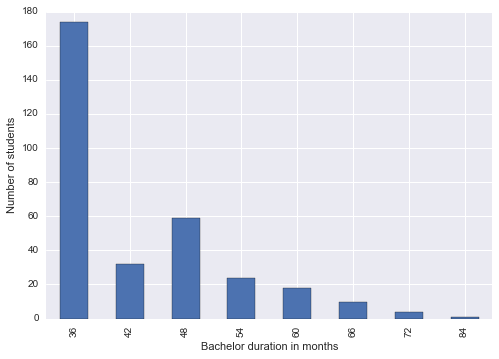

In [28]:
avg_duration_bachelor_degree = student_bachelor_done.groupby(['Durée bachelor (mois)']).count()['Nom Prénom'].plot(kind='bar')
avg_duration_bachelor_degree.set_ylabel('Number of students')
avg_duration_bachelor_degree.set_xlabel('Bachelor duration in months')

Before making the average by sex, we check if the values in the 'Civilité' colmun is correct :

In [29]:
student_bachelor_done['Civilité'].value_counts()

Monsieur    299
Madame       23
Name: Civilité, dtype: int64

In [30]:
student_bachelor_by_sex = student_bachelor_done[['Civilité', 'Durée bachelor (mois)']].groupby(['Civilité'])
student_bachelor_by_sex.mean()

,Durée bachelor (mois)
Civilité,
Madame,41.478261
Monsieur,43.123746


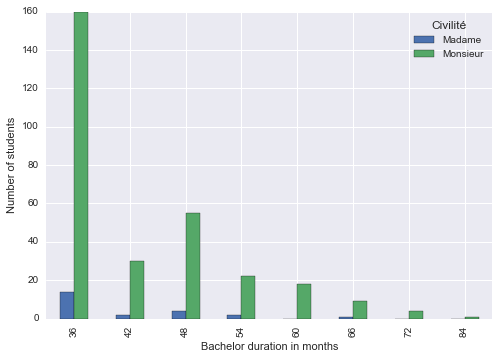

In [31]:
avg_duration_bachelor_degree_by_sex = student_bachelor_done.groupby(['Civilité', 'Durée bachelor (mois)']).count()['Nom Prénom'].unstack(level=0).fillna(0).plot(kind='bar')
avg_duration_bachelor_degree_by_sex.set_ylabel('Number of students')
avg_duration_bachelor_degree_by_sex.set_xlabel('Bachelor duration in months')
avg_duration_bachelor_degree_by_sex

It seams that female students obtain there bachelor degree in less months than male students in average. But the average is not a robust statistic value. We can check with the median :

In [32]:
student_bachelor_by_sex.median()

,Durée bachelor (mois)
Civilité,
Madame,36
Monsieur,36


As the median is a robust statistic and we don't see differences, the initial hypothesis that we have made is not correct. We can check again by making a T-Test to get the P-Value. The number of female or male students is sufficiant (N > 20) and the duration is independant between students, so we can approximate this with a normal distribution.

We need to test the hypothesis that female students success earlier than male students. The null hypothesis is that girl and boy are an average in duration equals. To do so, we will use the T-Test to find the P value :

In [33]:
boy_serie_duration_bachelor = student_bachelor_done['Durée bachelor (mois)'][[sex == 'Monsieur' for sex in student_bachelor_done['Civilité']]]
girl_serie_duration_bachelor = student_bachelor_done['Durée bachelor (mois)'][[sex == 'Madame' for sex in student_bachelor_done['Civilité']]]

stats.ttest_ind(a=boy_serie_duration_bachelor.values, b=girl_serie_duration_bachelor.values, equal_var=False)

Ttest_indResult(statistic=0.90887370316996541, pvalue=0.37155668685278143)

The P-Value is greater than the accepted value (0.18 > 0.05), we reject our hypothesis that female students finish earlier than male students.

We can do the same without aproximate with a normal distribution by using the K-S Test :

In [34]:
stats.ks_2samp(boy_serie_duration_bachelor.values, girl_serie_duration_bachelor.values)

Ks_2sampResult(statistic=0.073578595317725815, pvalue=0.99968681032438089)

Here, the null hypothesis is that the two samples are from the same distribution.

As P-value is high (>> 5%), we can't reject the null hypothesis ; in other words, there is no real difference here between the two samples (female and male students).

Note that the statistic value (i.e. the absolute max distance between the two cumulative distribution function) is close enought to 0, so, again, we can say that the two samples are from the same distribution.

### Extra

In [35]:
len(student_bachelor_done)

322

As we said before, we only consider the students who started their study at EPFL. Thus, we only obtain 397 students at the end, while for bachelor semester 6, we had 500+ entries.

# Question 2 - Master

<b>Perform a similar operation to what described above, this time for Master students. Notice that this data is more tricky, as there are many missing records in the IS-Academia database. Therefore, try to guess how much time a master student spent at EPFL by at least checking the distance in months between Master semestre 1 and Master semestre 2. If the Mineur field is not empty, the student should also appear registered in Master semestre 3. Last but not the least, don't forget to check if the student has an entry also in the Projet Master tables. Once you can handle well this data, compute the "average stay at EPFL" for master students. Now extract all the students with a Spécialisation and compute the "average stay" per each category of that attribute -- compared to the general average, can you find any specialization for which the difference in average is statistically significant?</b>

We have already fetch data from the IS-Academia in the first question. We won't do it again, we will just get data from files created with pickle. We apply the same process used in the bachelor section. But this time a master student can finish his master in different ways (***we are not EPFL students***, we assume this assumptions) :
 - 6) All students start with the master semester 1 or 2 but need to make both
 - 7) A student can finish with only master semester 1 and 2 without semester 3 if there isn't 'Mineur' value in semester 2
 - 8) A student can finish with semester 1 and 3 in case of missing data for semester 2
 - 9) A student can finish with an optional master projet in fall or spring but need to be registered in semester 1
 
We will fetch all data from files for semester 1, 2, 3 and fall or spring project. At the same time we will add the beginning date of every semester (like in bachelor) :

In [36]:
master_semester_codes = {}
for section_name in semester_codes:
    if section_name.startswith('Projet Master') or (section_name.startswith('Master semestre') and section_name.endswith(tuple(['1', '2', '3']))):
        master_semester_codes[section_name] = semester_codes[section_name]

def master_append_year(data_per_year, semester_name, year_name):
    if semester_name.endswith('2') or semester_name.endswith('printemps'):
        begin_date = year_name.split('-')[1] + '-02-01'
    else:
        begin_date = year_name.split('-')[0] + '-08-01'
    data_per_year[semester_name] = pd.to_datetime(begin_date)

master_dataframes = retrieve_dataframes(master_semester_codes, master_append_year)

Compute for Projet Master automne
Compute for Master semestre 3
Compute for Projet Master printemps
Compute for Master semestre 1
Compute for Master semestre 2


### Cleaning data

We also need to clean data like in bachelor. We will make the Sciper number in index and then remove duplicate rows after sort data by the date of the semester (ascending in semester 1 or descending in others cases) :

In [37]:
master_data_semester1 = master_dataframes['Master semestre 1'].copy()
master_data_semester2 = master_dataframes['Master semestre 2'].copy()
master_data_semester3 = master_dataframes['Master semestre 3'].copy()
master_data_semester_fall_project = master_dataframes['Projet Master automne'].copy()
master_data_semester_spring_project = master_dataframes['Projet Master printemps'].copy()

master_data_semester1.sort_values('Master semestre 1', ascending=True, inplace=True)
master_data_semester1.drop_duplicates(subset='No Sciper', keep='first', inplace=True)
master_data_semester1.set_index('No Sciper', inplace=True)

master_data_semester2.sort_values('Master semestre 2', ascending=False, inplace=True)
master_data_semester2.drop_duplicates(subset='No Sciper', keep='first', inplace=True)
master_data_semester2.set_index('No Sciper', inplace=True)

master_data_semester3.sort_values('Master semestre 3', ascending=False, inplace=True)
master_data_semester3.drop_duplicates(subset='No Sciper', keep='first', inplace=True)
master_data_semester3.set_index('No Sciper', inplace=True)

master_data_semester_fall_project.sort_values('Projet Master automne', ascending=False, inplace=True)
master_data_semester_fall_project.drop_duplicates(subset='No Sciper', keep='first', inplace=True)
master_data_semester_fall_project.set_index('No Sciper', inplace=True)

master_data_semester_spring_project.sort_values('Projet Master printemps', ascending=False, inplace=True)
master_data_semester_spring_project.drop_duplicates(subset='No Sciper', keep='first', inplace=True)
master_data_semester_spring_project.set_index('No Sciper', inplace=True)

For students in semester 2, we need to keep only students without minor values, because there are also in semester 3 (except students no registered for the next year so they will be automatically removed at the final merge).

In [38]:
master_data_semester2_without_mineur = master_data_semester2[[len(mineur) == 0 for mineur in master_data_semester2['Mineur']]]

### Merge and concat data

Now we need to make one dataframe for each assumptions 7, 8 and 9. To do so, we will make the needed attributes in index (name, sex, beginning date of the semester and sciper number) to prevent drop data when we will concat the 3 dataframes.

In [39]:
master_semester_1_2 = pd.merge(
    master_data_semester1[['Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1']],
    master_data_semester2_without_mineur[['Master semestre 2']],
    left_index=True,
    right_index=True,
    how='inner'
)
master_semester_1_2.reset_index(inplace=True)
master_semester_1_2.set_index(['No Sciper', 'Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1'], inplace=True)

master_semester_1_3 = pd.merge(
    master_data_semester1[['Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1']],
    master_data_semester3[['Master semestre 3']],
    left_index=True,
    right_index=True,
    how='inner'
)
master_semester_1_3.reset_index(inplace=True)
master_semester_1_3.set_index(['No Sciper', 'Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1'], inplace=True)

master_semester_1_pf = pd.merge(
    master_data_semester1[['Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1']],
    master_data_semester_fall_project[['Projet Master automne']],
    left_index=True,
    right_index=True,
    how='inner'
)
master_semester_1_pf.reset_index(inplace=True)
master_semester_1_pf.set_index(['No Sciper', 'Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1'], inplace=True)

master_semester_1_ps = pd.merge(
    master_data_semester1[['Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1']],
    master_data_semester_spring_project[['Projet Master printemps']],
    left_index=True,
    right_index=True,
    how='inner'
)
master_semester_1_ps.reset_index(inplace=True)
master_semester_1_ps.set_index(['No Sciper', 'Civilité', 'Nom Prénom', 'Spécialisation', 'Master semestre 1'], inplace=True)

Now we can concat dataframes in a single one and try to make only the Sciper number in index :

In [40]:
master_full_data = pd.concat([
        master_semester_1_2[['Master semestre 2']],
        master_semester_1_3[['Master semestre 3']],
        master_semester_1_pf[['Projet Master automne']],
        master_semester_1_ps[['Projet Master printemps']]
    ], axis=1)

In [41]:
# Check if the No Sciper is still unique
master_full_data.index.levels[0].is_unique

True

In [42]:
master_full_data.reset_index(inplace=True)
master_full_data.set_index(['No Sciper'], inplace=True)

master_full_data.head()

,Civilité,Nom Prénom,Spécialisation,Master semestre 1,Master semestre 2,Master semestre 3,Projet Master automne,Projet Master printemps
No Sciper,,,,,,,,
147008,Monsieur,Good Xavier,"Signals, Images and Interfaces",2011-08-01,2013-02-01,2012-08-01,NaT,NaT
161220,Monsieur,Tourino Pablo,,2009-08-01,2010-02-01,2010-08-01,NaT,NaT
161279,Monsieur,Biollay Jean Isaac Jamal Pachacutec,,2009-08-01,2010-02-01,2010-08-01,NaT,2011-02-01
161814,Monsieur,Candemir Mehmet,,2009-08-01,2010-02-01,2010-08-01,NaT,NaT
161930,Monsieur,Lunang Pomkam Auguste Carmen,,2010-08-01,2011-02-01,2011-08-01,NaT,NaT


We can see, that the student with the Sciper number 152232 correspond to the assumption 8 because he hasn't data for semester 2. We decided to keep this kind of entries because there are a lot :

In [43]:
master_full_data[master_full_data['Master semestre 2'].isnull()]

,Civilité,Nom Prénom,Spécialisation,Master semestre 1,Master semestre 2,Master semestre 3,Projet Master automne,Projet Master printemps
No Sciper,,,,,,,,
170220,Monsieur,Barras Florian,,2009-08-01,NaT,2011-08-01,NaT,NaT
170225,Monsieur,Burgener Raphaël,,2009-08-01,NaT,2010-08-01,NaT,NaT
170451,Monsieur,Bolkensteyn Dinesh,,2009-08-01,NaT,2010-08-01,NaT,NaT
171073,Monsieur,Jiekak Ndeutou Stève Aurélien,Internet computing,2009-08-01,NaT,2010-08-01,NaT,NaT
174774,Monsieur,Balas Martin,,2010-08-01,NaT,2011-08-01,NaT,NaT
174905,Monsieur,Aubelle Flavien,,2012-08-01,NaT,2013-08-01,NaT,NaT
176564,Monsieur,Helfer Jonas,,2009-08-01,NaT,2010-08-01,NaT,NaT
178706,Madame,Falbriard Stéphanie,,2010-08-01,NaT,2011-08-01,NaT,NaT
179449,Monsieur,Bindschaedler Vincent,,2010-08-01,NaT,2011-08-01,NaT,NaT


We set the NaT date values with the earliest date to compute without errors the number of semesters. This will be apply only in semester 2, 3 and projects because the previous merging prevent missing data in the semester 1.

In [44]:
#master_full_data.fillna(0, inplace=True)

Now we can compute the number of months by compare the date in semester 1 with the lastest date in semester 2, 3 or projects :

In [45]:
# We need to find the lastest and earliest date between semester 1, 2, 3 or projects
# because some students start with the semester 2 then the 1
def lastest_date(dates):
    return max(dates[[not pd.isnull(date) for date in dates]])
def earliest_date(dates):
    return min(dates[[not pd.isnull(date) for date in dates]])

def compute_nb_months_master(row):
    lastest = lastest_date(row[['Master semestre 1', 'Master semestre 2', 'Master semestre 3', 'Projet Master automne', 'Projet Master printemps']])
    earliest = earliest_date(row[['Master semestre 1', 'Master semestre 2']])
    delta = relativedelta.relativedelta(lastest, earliest) 
    return delta.years * 12 + delta.months + 6

master_full_data['Durée master (mois)'] = master_full_data.apply(compute_nb_months_master, axis=1)

master_full_data.head()

,Civilité,Nom Prénom,Spécialisation,Master semestre 1,Master semestre 2,Master semestre 3,Projet Master automne,Projet Master printemps,Durée master (mois)
No Sciper,,,,,,,,,
147008,Monsieur,Good Xavier,"Signals, Images and Interfaces",2011-08-01,2013-02-01,2012-08-01,NaT,NaT,24
161220,Monsieur,Tourino Pablo,,2009-08-01,2010-02-01,2010-08-01,NaT,NaT,18
161279,Monsieur,Biollay Jean Isaac Jamal Pachacutec,,2009-08-01,2010-02-01,2010-08-01,NaT,2011-02-01,24
161814,Monsieur,Candemir Mehmet,,2009-08-01,2010-02-01,2010-08-01,NaT,NaT,18
161930,Monsieur,Lunang Pomkam Auguste Carmen,,2010-08-01,2011-02-01,2011-08-01,NaT,NaT,18


### Statistics

In [46]:
master_full_data['Durée master (mois)'].mean()

20.127527216174183

In [47]:
master_full_data.groupby(['Spécialisation']).mean()

,Durée master (mois)
Spécialisation,
,19.893654
Computer Engineering - SP,22.000000
Data Analytics,15.000000
Foundations of Software,23.500000
Information Security - SP,30.000000
Internet computing,21.900000
Service science,18.000000
"Signals, Images and Interfaces",23.142857
Software Systems,23.000000


In [48]:
master_full_data.groupby(['Spécialisation']).median()

,Durée master (mois)
Spécialisation,
,18
Computer Engineering - SP,24
Data Analytics,15
Foundations of Software,24
Information Security - SP,30
Internet computing,24
Service science,18
"Signals, Images and Interfaces",24
Software Systems,21


In [54]:
master_full_data.groupby(['Spécialisation']).count()[['Durée master (mois)']]

,Durée master (mois)
Spécialisation,
,583
Computer Engineering - SP,3
Data Analytics,2
Foundations of Software,12
Information Security - SP,1
Internet computing,20
Service science,2
"Signals, Images and Interfaces",14
Software Systems,6


Here the t-test shoul not be appropriate, in deed the number of student with a 'specialisation' is not big enought to be approximate by a normal distibution.
Moreover we don't have any information about the distibution of the data where we are going to study.

The k-test seems appropriate for 'Specialisation' greater than 5 people, in order to compare distribution with enough value. (We remove to the study 'Computer Engineering - SP','Data Analytics','Information Security - SP', 'Service science')
The test are going to show if a 'Specialisation' is statiscally close to the data related to master student

In [57]:
global_duration_serie = master_full_data['Durée master (mois)'].values
specialities_duration_series = {}

for speciality in master_full_data['Spécialisation'].unique():
    #if len(speciality) > 0:
        specialities_duration_series[speciality] = master_full_data['Durée master (mois)'][[spe == speciality for spe in master_full_data['Spécialisation']]].values

for speciality_name, speciality_serie in specialities_duration_series.items():
    print(speciality_name + ' : ', end='')
    print(stats.ks_2samp(global_duration_serie, speciality_serie))

 : Ks_2sampResult(statistic=0.022671920057406703, pvalue=0.99726167944515676)
Signals, Images and Interfaces : Ks_2sampResult(statistic=0.31315263274827815, pvalue=0.10903414592543681)
Foundations of Software : Ks_2sampResult(statistic=0.25362882322446861, pvalue=0.38032363291845511)
Service science : Ks_2sampResult(statistic=0.3297045101088647, pvalue=0.94077673716635579)
Internet computing : Ks_2sampResult(statistic=0.22029548989113529, pvalue=0.26769611351124167)
Computer Engineering - SP : Ks_2sampResult(statistic=0.33696215655780198, pvalue=0.80099175446523385)
Software Systems : Ks_2sampResult(statistic=0.1702954898911353, pvalue=0.98937827400175837)
Information Security - SP : Ks_2sampResult(statistic=0.83359253499222397, pvalue=0.24441573975866812)
Data Analytics : Ks_2sampResult(statistic=0.33048211508553654, pvalue=0.93968744116230585)


the null-hypothesis for the KT test is that the distributions are the same.
Thus, the lower your p value the greater the statistical evidence we have to reject the null hypothesis and 
conclude the distributions are different.

if we take alpha = 5%, we can reject the null-hypothesis for all Specialisation except for Software of fundation.

# Bonus

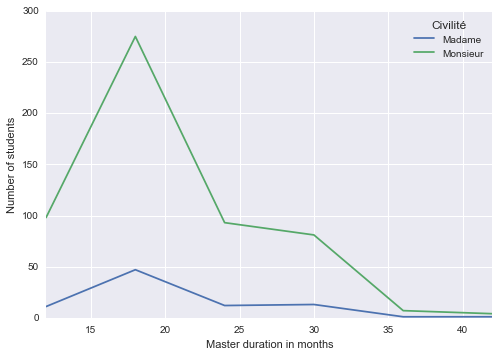

In [58]:
avg_duration_master_degree_by_sex = master_full_data.groupby(['Civilité', 'Durée master (mois)']).count()['Nom Prénom'].unstack(level=0).fillna(0).plot()
avg_duration_master_degree_by_sex.set_ylabel('Number of students')
avg_duration_master_degree_by_sex.set_xlabel('Master duration in months')
avg_duration_master_degree_by_sex